In [18]:
import torch
from torch import nn, optim, tensor
import torch.nn.functional as F
import torchvision
import torchvision.transforms.functional as TF
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader
import time

import math
import glob
from PIL import Image

In [19]:
class DoubleConvolution(nn.Module):
    def __init__(self, n_in, n_out):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(n_in, n_out, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Conv2d(n_out, n_out, kernel_size=3, stride=1),
            nn.ReLU()
        )
        
    def forward(self, x):
        return self.net(x)

In [20]:
class Downsample(nn.Module):
    def __init__(self, scale=2):
        super().__init__()
        self.pool = nn.MaxPool2d(scale)
        
    def forward(self, x):
        return self.pool(x)

In [21]:
class Upsample(nn.Module):
    def __init__(self, n_in, n_out, scale=2):
        super().__init__()
        self.up_pool = nn.UpsamplingNearest2d(scale_factor=scale)
        self.conv = nn.Conv2d(n_in, n_out, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        return self.relu(self.conv(self.up_pool(x)))

In [22]:
class CropAndCat(nn.Module):
    def forward(self, x, proj_tns):
        proj = TF.center_crop(proj_tns, [x.shape[2], x.shape[3]])
        out = torch.cat([x, proj], dim=1)
        return out

In [23]:
channels = [64, 128, 256, 512, 1024]
class UNet(nn.Module):
    def __init__(self, input_channels, output_channels):
        super().__init__()
        self.first = DoubleConvolution(input_channels, channels[0])
        self.down_double_convs = nn.ModuleList([DoubleConvolution(channels[i], channels[i+1]) for i in range(len(channels)-1)])
        self.down_samples = nn.ModuleList([Downsample() for i in range(4)])
        
        self.up_double_convs = nn.ModuleList([DoubleConvolution(channels[i], channels[i-1]) for i in range(-1, -len(channels), -1)])
        self.up_samples = nn.ModuleList([Upsample(channels[i], channels[i-1]) for i in range(-1, -len(channels), -1)])
        self.crop_and_cat = nn.ModuleList([CropAndCat() for i in range(4)])
        
        self.last = nn.Conv2d(channels[0], output_channels, kernel_size=1, stride=1)
        
    def forward(self, x):
        x = self.first(x)
        pass_through = []
        pass_through.append(x)
        for i, mod in enumerate(self.down_double_convs):
            x = self.down_samples[i](x)
            x = mod(x)
            pass_through.append(x)

        pass_through.pop() # get rid of the last projection since its not needed
        for i, mod in enumerate(self.up_double_convs):
            x = self.up_samples[i](x)
            
            proj = pass_through.pop()
            x = self.crop_and_cat[i](x, proj)
            x = mod(x)
        
        x = self.last(x)
        return x

In [24]:
def init_weights(m):
    if isinstance(m, (torch.nn.Conv2d, torch.nn.ConvTranspose2d)):
        torch.nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            torch.nn.init.constant_(m.bias, 0)

In [25]:
def normalize(tns):
    return (tns - tns.mean())/tns.std()

In [32]:
class Carvana(Dataset):
    def __init__(self, path):
        self.x = []
        self.y = []
        
        for filename in sorted(glob.glob(f"{path}/train/*")):
            self.x.append(filename)
            
        for filename in sorted(glob.glob(f"{path}/train_masks/*")):
            self.y.append(filename)
        
        self.tfs = torchvision.transforms.Compose([
            torchvision.transforms.Resize(572),
            torchvision.transforms.ToTensor()
        ])
        
    def __getitem__(self, i):
        img = self.tfs(Image.open(self.x[i]))
        mask = self.tfs(Image.open(self.y[i]))
        mask /= mask.max() # rescale the mask values since they aren't 1
        return img, mask
    
    def __len__(self):
        return len(self.x)

In [49]:
ds = Carvana("./data/carvana")

In [53]:
bs = 4
dl = DataLoader(ds, batch_size=bs)
accum_size = 32

In [54]:
model = UNet(3, 1).to('cuda')
model.apply(init_weights)
torch.set_float32_matmul_precision('high')
model.compile()
dl_iter = iter(dl)
lr = 3e-5
opt = optim.AdamW(model.parameters(), lr=lr)

In [55]:
epochs = 5
sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, epochs * len(dl) // accum_size, 0.5 * lr)
model.train()
for i in range(epochs):
    dl_pos = 0
    accum_iter = 0
    # gradient accumulation 
    while dl_pos < len(dl):
        loss_accum = 0.0
        opt.zero_grad()

        accum_steps = accum_size // bs if len(dl) - dl_pos >= accum_size else math.ceil((len(dl) - dl_pos) / bs)
        
        ti = time.time()
        print(accum_steps)
        for accum_it in range(accum_steps):
            dl_pos += bs
            xb, yb = next(dl_iter)
            xb, yb = xb.to('cuda'), yb.to('cuda')

            with torch.autocast('cuda', torch.bfloat16):
                logits = model(xb)
                yb = TF.center_crop(yb, (logits.shape[-2], logits.shape[-1]))
                loss = F.binary_cross_entropy_with_logits(logits, yb)

            loss /= accum_steps
            loss_accum += loss.detach()
            loss.backward()
            
        opt.step()
        dt = time.time() - ti
        
        print(f"Epoch: {i} | dl_pos: {dl_pos} | Iteration: {accum_iter} | loss: {loss_accum} | time: {dt}s | Images/sec: {accum_size / dt}")
        accum_iter += 1
        sched.step()
        
    dl_iter = iter(dl)

8
Epoch: 0 | dl_pos: 32 | Iteration: 0 | loss: 0.9673033356666565 | time: 2.512294054031372s | Images/sec: 12.737362471025616
8
Epoch: 0 | dl_pos: 64 | Iteration: 1 | loss: 0.6681870818138123 | time: 2.72426176071167s | Images/sec: 11.746301497709423
8
Epoch: 0 | dl_pos: 96 | Iteration: 2 | loss: 0.5314534306526184 | time: 2.1743500232696533s | Images/sec: 14.717041717083056
8
Epoch: 0 | dl_pos: 128 | Iteration: 3 | loss: 0.5793492197990417 | time: 1.8766207695007324s | Images/sec: 17.05192680379077
8
Epoch: 0 | dl_pos: 160 | Iteration: 4 | loss: 0.965701162815094 | time: 2.4513673782348633s | Images/sec: 13.053938909410627
8
Epoch: 0 | dl_pos: 192 | Iteration: 5 | loss: 0.5997593998908997 | time: 2.4857406616210938s | Images/sec: 12.873426618499682
8
Epoch: 0 | dl_pos: 224 | Iteration: 6 | loss: 0.7326869368553162 | time: 2.5369386672973633s | Images/sec: 12.6136277602998
8
Epoch: 0 | dl_pos: 256 | Iteration: 7 | loss: 0.5758947730064392 | time: 2.473933696746826s | Images/sec: 12.934

In [56]:
ds[0][0].shape, ds[0][1].shape

(torch.Size([3, 572, 857]), torch.Size([1, 572, 857]))

In [57]:
idx = 32
a = ds[idx][0].to('cuda').unsqueeze(0)
b = ds[idx][1].to('cuda').unsqueeze(0)

In [58]:
model.eval()
mask = torch.sigmoid(model(a))

In [59]:
def to_image(tns):
    return TF.to_pil_image(tns)

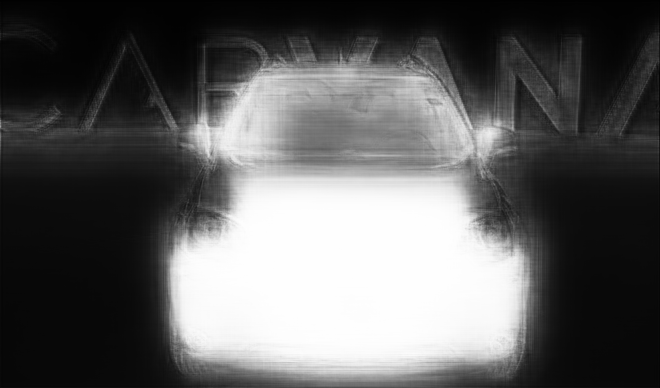

In [60]:
to_image(mask.squeeze())

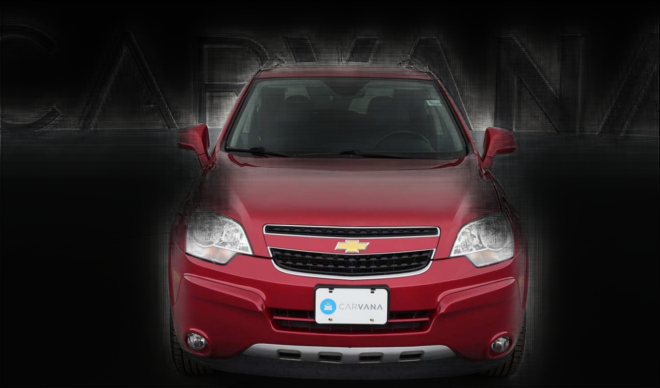

In [61]:
_, _, w, h = logits.shape
to_image((TF.center_crop(a, (w, h)) * mask.squeeze()).squeeze())